**Intelligent Systems for Pattern Recognition Course - Midterm 2**
## Hidden Markov Model - Assignment 1
Giulia Ghisolfi, role number: 664266

Import libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import norm
import os
import warnings
from hmmlearn.hmm import GaussianHMM, GMMHMM # Continuous HMM
from hmmlearn.hmm import CategoricalHMM, PoissonHMM # Discrete HMM

c:\Users\giuli\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## 1. Dataset

### 1.1 Data Loading and Preparation

In [2]:
# load data
DATA_PATH = 'air+quality/AirQualityUCI.csv'
data_df = pd.read_csv(DATA_PATH, sep=';')

In [3]:
data_df.shape # 9357 measures: one each hour from 10/03/2004 18:00:00 to 04/04/2005 14:00:00

(9471, 17)

| Variable Name | Role        | Type       | Description                                                        | Units       | Missing Values |
|---------------|-------------|------------|--------------------------------------------------------------------|-------------|----------------|
| Date          | Feature     | Date       | -                                                                  | -           | no             |
| Time          | Feature     | Categorical| -                                                                  | -           | no             |
| CO(GT)        | Feature     | Integer    | True hourly averaged concentration CO in mg/m^3 (reference analyzer)| mg/m^3      | no             |
| PT08.S1(CO)   | Feature     | Categorical| hourly averaged sensor response (nominally CO targeted)            | -           | no             |
| NMHC(GT)      | Feature     | Integer    | True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer) | microg/m^3 | no             |
| C6H6(GT)      | Feature     | Continuous | True hourly averaged Benzene concentration in microg/m^3 (reference analyzer) | microg/m^3 | no             |
| PT08.S2(NMHC) | Feature     | Categorical| hourly averaged sensor response (nominally NMHC targeted)          | -           | no             |
| PT08.S4(NO2)  | Feature     | Categorical| hourly averaged sensor response (nominally NO2 targeted)           | -           | no             |
| PT08.S5(O3)   | Feature     | Categorical| hourly averaged sensor response (nominally O3 targeted)            | -           | no             |
| T             | Feature     | Continuous | Temperature                                                        | °C          | no             |
| RH            | Feature     | Continuous | Relative Humidity                                                  | %           | no             |
| AH            | Feature     | Continuous | Absolute Humidity                                                  | -           | no             |
| NOx(GT)       | Feature     | Integer    | True hourly averaged NOx concentration in ppb (reference analyzer) | ppb         | no             |
| PT08.S3(NOx)  | Feature     | Categorical| hourly averaged sensor response (nominally NOx targeted)          | -           | no             |
| NO2(GT)       | Feature     | Integer    | True hourly averaged NO2 concentration in microg/m^3 (reference analyzer) | microg/m^3 | no             |


In [4]:
for column in ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
    'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
    'PT08.S5(O3)', 'T', 'RH', 'AH']:
    data_df[column] = data_df[column].replace(',', '.', regex=True)
    data_df[column] = data_df[column]

data_df = data_df.drop(columns=['Unnamed: 15', 'Unnamed: 16'])
data_df = data_df.dropna()
data_df = data_df.drop_duplicates()

In [5]:
# cast types
for column in ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
    'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
    'PT08.S5(O3)', 'T', 'RH', 'AH']:
    data_df[column] = data_df[column].astype(float)

In [6]:
MISSING_VALUES = -200

# replace missing values with NaN
data_df = data_df.replace(-200, np.nan)

In [7]:
data_df.head(2)

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255


In [8]:
# visualize missing values in the dataset
display(data_df.isnull().sum())

Date                0
Time                0
CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
dtype: int64

### 1.2 Choose sensor data

The dataset consists of 9357 measurements, each taken hourly from 10/03/2004 18:00:00 to 04/04/2005 14:00:00.

We selected the temperature sensor for analysis, as it provides continuous measurements with minimal missing values compared to other sensors.

Below, we display the time series plot, some descriptive statistics, and a histogram illustrating the distribution of the data.

In [9]:
sensor_name = 'T' # Temperature
unit_measure = '°C'

In [10]:
def visualize_ts(time_serie, title, unit_measure, date_from=pd.to_datetime('2004-03-10 18:00:00'),
    date_to=pd.to_datetime('2005-04-04 14:00:00'), scale='linear'):
    plt.figure(figsize=(18, 3))
    time_index = pd.date_range(start=date_from, end=date_to, freq='h')
    plt.plot(time_index, time_serie, color='k', linewidth=0.4)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
    plt.xlim(date_from, date_to)
    plt.xticks(rotation=90)
    plt.xlabel('Date (1 hour interval)')
    plt.ylabel(unit_measure)
    plt.yscale(scale)
    plt.title(title)
    plt.show()

def visualize_hist(time_serie, title, unit_measure, bins=100):
    plt.figure(figsize=(18, 3))
    plt.hist(time_serie, bins=bins, color='k', alpha=0.4, edgecolor='black', label='Observations')
    plt.title(title)
    plt.legend()
    plt.xlabel(unit_measure)
    plt.ylabel('Frequency')
    plt.show()

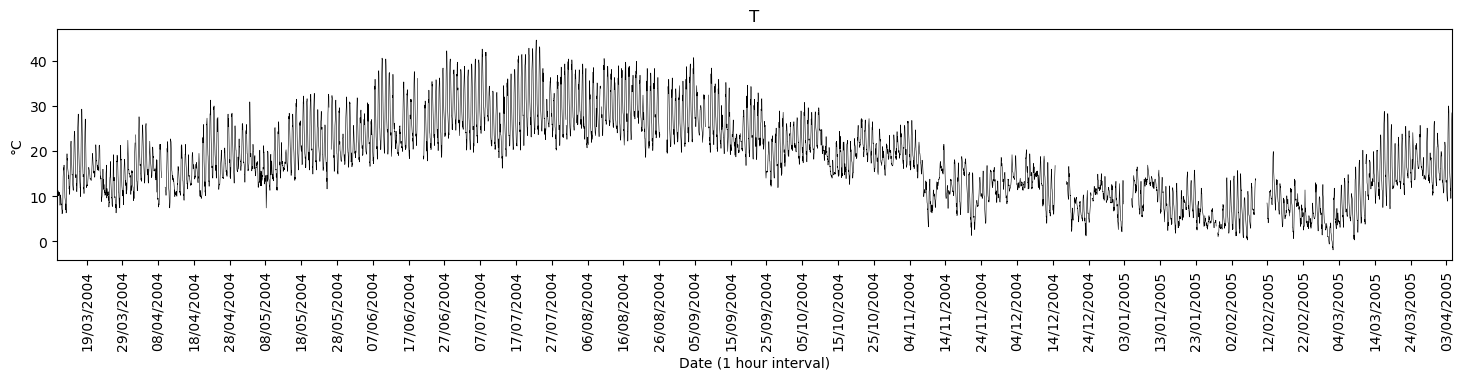

In [11]:
visualize_ts(time_serie=data_df[sensor_name], title=sensor_name, unit_measure=unit_measure)

The time series exhibits numerous oscillations, as expected (temperature variations occur between day and night), with peak values reached between early June and midle of September, and minimum values occurring between November and March.

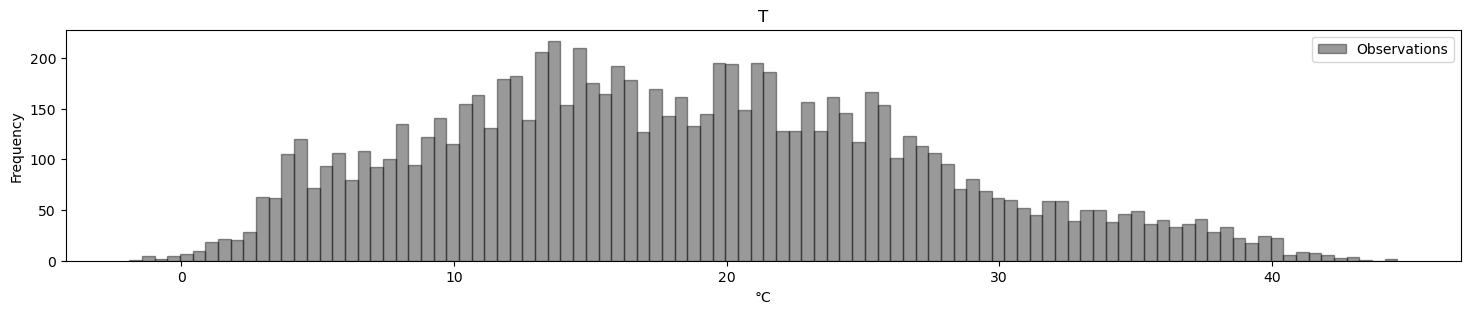

In [12]:
visualize_hist(time_serie=data_df[sensor_name], title=sensor_name, unit_measure=unit_measure)

In [13]:
display(data_df[sensor_name].describe())
print('Number of missing values:', data_df[sensor_name].isnull().sum())

count    8991.000000
mean       18.317829
std         8.832116
min        -1.900000
25%        11.800000
50%        17.800000
75%        24.400000
max        44.600000
Name: T, dtype: float64

Number of missing values: 366


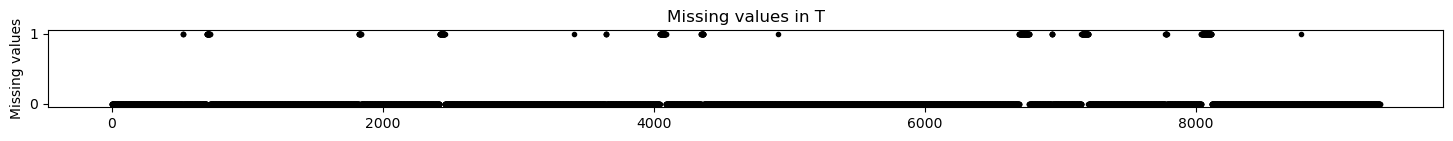

In [14]:
def visualize_missing_values(time_serie, title):
    plt.figure(figsize=(18, 1))
    plt.plot(time_serie.isnull().astype(int), '.k')
    plt.title(title)
    plt.ylabel('Missing values')
    plt.show()

# visualize missing values in the time serie
visualize_missing_values(data_df[sensor_name], title='Missing values in ' + sensor_name)

### 1.3 Fill Missing Value

We fill missing values using the moving average method with a window size of window_size. If the value at time t is missing, it will be replaced by the average of the values at times t-1, t-2, ..., t-window_size.

In [15]:
def moving_average(data, window_size):
    moving_average_series = data.rolling(window=window_size, min_periods=24).mean()
    data = data.to_numpy()

    # fill missing values
    for i in range(len(data)):
        if np.isnan(data[i]):
            data[i] = moving_average_series[i]

    return data

In [16]:
data = moving_average(data_df[sensor_name], window_size=100)
data = data.reshape(-1, 1) # reshape to 2D array to make it compatible with hmmlearn library

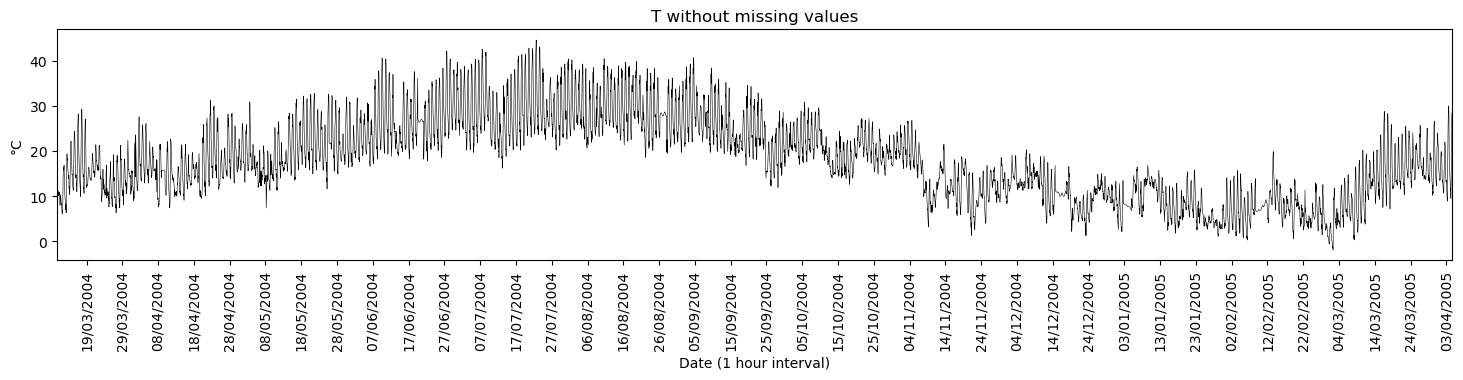

In [17]:
visualize_ts(data, title=sensor_name+' without missing values', unit_measure=unit_measure)

In [18]:
print('Average: {:.2f}'.format(np.mean(data)))
print('Std: {:.2f}'.format(np.std(data)))

Average: 18.19
Std: 8.85


### 1.4 Data Preprocessing

We performed data preprocessing on the time series to conduct a more in-depth investigation.

#### Normalize data
We normalize the data to reduce variance among the data while maintaining consistent value scales.

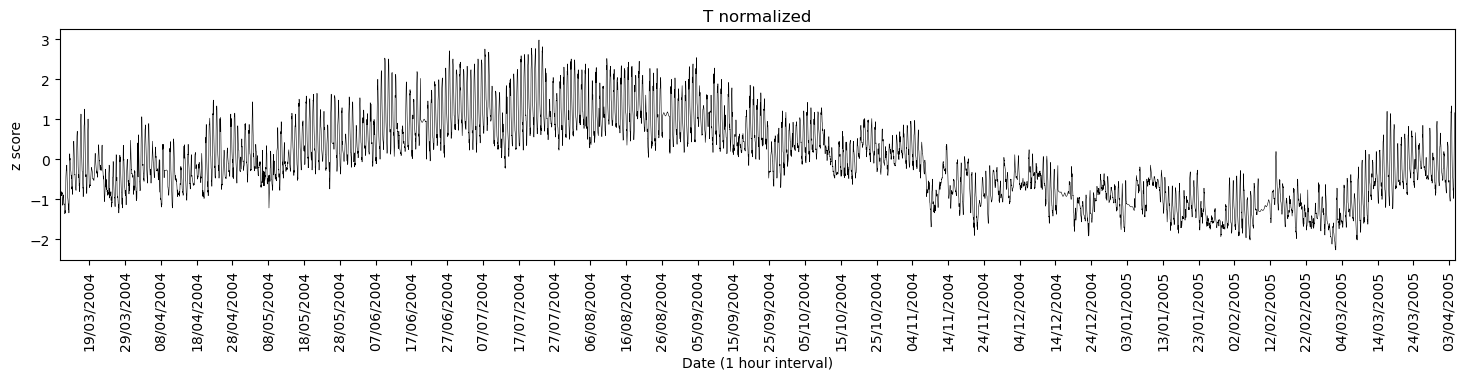

In [19]:
data_normalized = (data - np.mean(data)) / np.std(data)

visualize_ts(data_normalized, title=sensor_name+' normalized', unit_measure='z score')

#### Linearize data
We linearize the data to conduct a more in-depth analysis of temperature variation between day and night, without taking into account the seasonality of the data during the year.

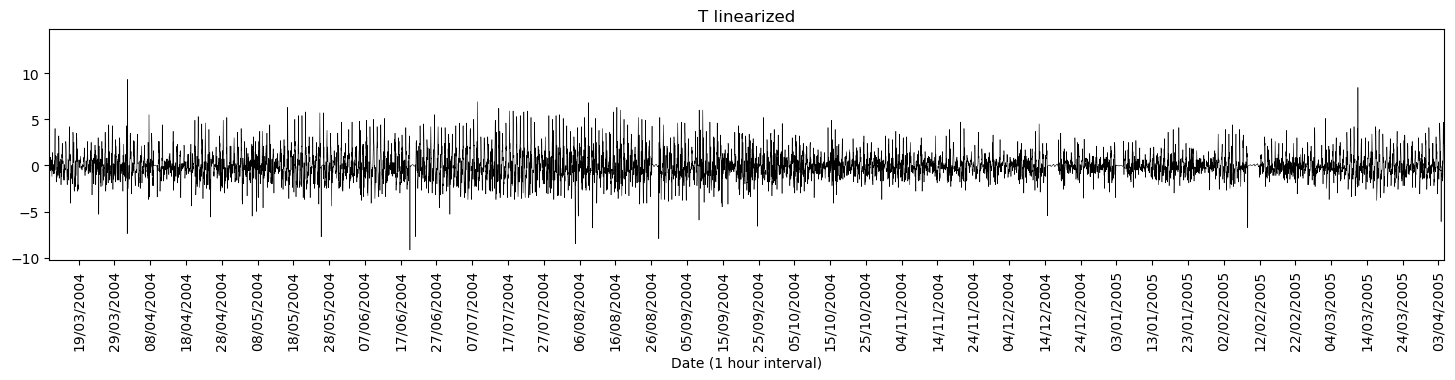

In [20]:
data_linearized = np.diff(np.concatenate((np.zeros((1, 1)), data), axis=0), axis=0) # linearize the time serie
visualize_ts(data_linearized, title=sensor_name+' linearized', unit_measure='')

#### Discetize data
To use discrete HMMs with discrete probability emissions, we discretise the time series data and translate it so that th minimum value is set to 0.

In [21]:
data.min(), data.max()

(-1.9, 44.6)

In [22]:
data_discretized = np.floor(data) # discretize data
data_discretized = data_discretized - data_discretized.min() # set min value to 0
data_discretized = data_discretized.astype(int)

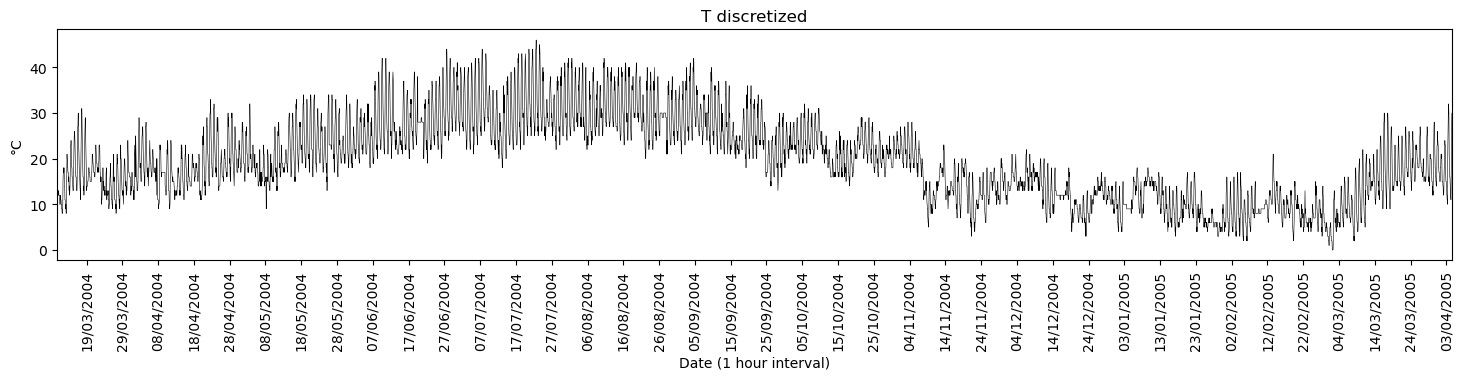

In [23]:
visualize_ts(data_discretized, title=sensor_name+' discretized', unit_measure=unit_measure)

### 1.5 Split Data into Train and Test Sets

In [24]:
train_size = int(0.75 * len(data_discretized)) # 75% of the data for training, 25% for testing

train_data = data[:train_size]
test_data = data[train_size:]

train_data_normalized = data_normalized[:train_size]
test_data_normalized = data_normalized[train_size:]

train_data_linearized = data_linearized[:train_size]
test_data_linearized = data_linearized[train_size:]

train_data_discretized = data_discretized[:train_size]
test_data_discretized = data_discretized[train_size:]

In [25]:
data_set_dict = {
    # name: [train_data, test_data, data_type]
    'continuous': [train_data, test_data, 'continuous'],
    'continuous normalized': [train_data_normalized, test_data_normalized, 'continuous'],
    'continuous linearized': [train_data_linearized, test_data_linearized, 'continuous'],
    'discrete': [train_data_discretized, test_data_discretized, 'discrete']
}

## 2. HMM: Code Implementation

In [26]:
os.environ["OMP_NUM_THREADS"] = "1" # to avoid warning message

In [27]:
N_HIDDEN_STATES = [2, 3, 4, 5, 6, 7, 8, 9, 10]
RANDOM_STATE = 42 # random state for reproducibility

### 2.1 Hidden Markov Model Implementation Functions

In [28]:
def fit_continuous_hmm_model(data, n_components, model_name, algorithm='viterbi'):
    """
    Fit a continuous HMM model.

    Args:
        data (ndarray): Time serie.
        n_components (int): Number of hidden states.
        model_name (str): Name of the model ('GaussianHMM' or 'GMMHMM').
        algorithm (str): Decoding algorithm ('viterbi' or 'map').

    Returns:
        model: Fitted HMM model.
    """
    if model_name == 'GaussianHMM':
        model = GaussianHMM(
                n_components=n_components, # number of hidden states
                covariance_type='full',
                n_iter=1000,
                algorithm=algorithm,
                random_state=RANDOM_STATE
                )
    elif model_name == 'GMMHMM':
        model = GMMHMM(
                n_components=n_components, # number of hidden states
                n_mix=1, # number of mixtures in GMM
                covariance_type='full',
                n_iter=1000,
                algorithm=algorithm,
                random_state=RANDOM_STATE
                )
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        model.fit(data)
    return model

def fit_discrete_hmm_model(data, n_components, model_name, algorithm='viterbi'):
    """
    Fit a discrete HMM model.

    Args:
        data (ndarray): Time serie.
        n_components (int): Number of hidden states.
        model_name (str): Name of the model ('CategoricalHMM' or 'PoissonHMM').
        algorithm (str): Decoding algorithm ('viterbi' or 'map').

    Returns:
        model: Fitted HMM model.
    """
    if model_name == 'CategoricalHMM':
        model = CategoricalHMM(
                n_components=n_components, # number of hidden states
                n_iter=1000,
                algorithm=algorithm,
                random_state=RANDOM_STATE
                )
    elif model_name == 'PoissonHMM':
        model = PoissonHMM(
                n_components=n_components, # number of hidden states
                n_iter=1000,
                algorithm=algorithm,
                random_state=RANDOM_STATE
                )
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        model.fit(data)
    return model

def predict_hmm_states(model, data):
    """
    Predict hidden states using a HMM model.

    Args:
        model: Fitted HMM model.
        data (ndarray): Time serie.

    Returns:
        ndarray: Predicted hidden states.
    """
    return model.predict(data)

def compute_hmm_score(model, data):
    """
    Compute log likelihood, BIC and AIC scores for a HMM model.

    Args:
        model: Fitted HMM model.
        data (ndarray): Time serie.

    Returns:
        tuple: Log likelihood, BIC and AIC scores.
    """
    log_likelihood = model.score(data)
    bic = model.bic(data) # Bayesian Information Criterion
    aic = model.aic(data) # Akaike Information Criterion
    return log_likelihood, bic, aic

### 2.2 Visualization Functions

In [29]:
def visualize_hmm_states(time_serie, states, n_components, model_name, unit_measure, 
    date_from=pd.to_datetime('2004-03-10 18:00:00'), date_to=pd.to_datetime('2005-04-04 14:00:00')):
    plt.figure(figsize=(18, 3))
    """
    Visualize hidden states assigned by a HMM model.

    Args:
        time_serie (ndarray): Time serie.
        states (ndarray): Hidden states assigned by the HMM model.
        n_components (int): Number of hidden states.
        model_name (str): Name of the model.
        unit_measure (str): Unit of measure.
        date_from (datetime): Start date.
        date_to (datetime): End date.
    """
    time_index = pd.date_range(start=date_from, end=date_to, freq='h')
    plt.plot(time_index, time_serie, 'k', linewidth=0.3, label='Time serie')
    for i in range(n_components):
        state_index = [idx for idx, state in enumerate(states) if state == i]
        plt.scatter(time_index[state_index], time_serie[state_index], s=8, label='State '+str(i))
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
    plt.xlim(date_from, date_to)
    plt.xticks(rotation=90)
    plt.xlabel('Date (1 hour interval)')
    plt.title(f'Hidden States Assigned by {model_name} ({n_components} states)')
    plt.ylabel(unit_measure)
    plt.show()

def visualize_hmm_states_transition_matrix(model, n_components, model_name):
    """
    Visualize transition matrix of a HMM model.

    Args:
        model: Fitted HMM model.
        n_components (int): Number of hidden states.
        model_name (str): Name of the model.
    """
    plt.figure(figsize=(4, 4))
    plt.imshow(model.transmat_, cmap='Blues', interpolation='nearest')
    for i in range(model.transmat_.shape[0]):
        for j in range(model.transmat_.shape[1]):
            plt.text(j, i, '{:.2f}'.format(model.transmat_[i, j]), ha='center', 
            va='center', fontsize=6, color='black')
    plt.xticks(np.arange(model.n_components))
    plt.yticks(np.arange(model.n_components))
    plt.title(f'Transition matrix {model_name} ({n_components} states)')
    plt.show()

def visualize_discrete_hmm_emission_matrix(model, n_components, model_name):
    """
    Visualize emission matrix of a discrete HMM model.

    Args:
        model: Fitted HMM model.
        n_components (int): Number of hidden states.
        model_name (str): Name of the model.
    """
    plt.figure(figsize=(18, 4))
    plt.imshow(model.emissionprob_, cmap='Blues', interpolation='nearest')
    for i in range(model.emissionprob_.shape[0]):
        for j in range(model.emissionprob_.shape[1]):
            plt.text(j, i, '{:.2f}'.format(model.emissionprob_[i, j]), ha='center', 
            va='center', fontsize=6, color='black')
    plt.xticks(np.arange(model.emissionprob_.shape[1]))
    plt.yticks(np.arange(model.emissionprob_.shape[0]))
    plt.title(f'Emission matrix {model_name} ({n_components} states)')
    plt.show()

def visualize_hmm_prior_vector(model, n_components, model_name):
    """
    Visualize prior vector of a HMM model.

    Args:
        model: Fitted HMM model.
        n_components (int): Number of hidden states.
        model_name (str): Name of the model.
    """
    plt.figure(figsize=(1, 4))
    plt.imshow(model.startprob_.reshape(-1, 1), cmap='Blues', interpolation='nearest')
    for i in range(model.startprob_.shape[0]):
        plt.text(0, i, '{:.2f}'.format(model.startprob_[i]), ha='center', 
        va='center', fontsize=6, color='black')
    plt.xticks([])
    plt.yticks(np.arange(model.startprob_.shape[0]))
    plt.title(f'Prior {model_name} ({n_components} states)')
    plt.show()

In [30]:
def visualize_different_states_assigned(time_serie, states1, states2, n_components, model_name1, model_name2,
    unit_measure, date_from=pd.to_datetime('2004-03-10 18:00:00'), date_to=pd.to_datetime('2005-04-04 14:00:00')):
    """
    Visualize different states assigned by two HMM models on the same time serie.

    Args:
        time_serie (ndarray): Time serie.
        states1 (ndarray): Hidden states assigned by the first HMM model.
        states2 (ndarray): Hidden states assigned by the second HMM model.
        n_components (int): Number of hidden states.
        model_name1 (str): Name of the first model.
        model_name2 (str): Name of the second model.
        unit_measure (str): Unit of measure.
        date_from (datetime): Start date.
        date_to (datetime): End date.
    """
    plt.figure(figsize=(18, 3))
    time_index = pd.date_range(start=date_from, end=date_to, freq='h')
    plt.plot(time_index, time_serie, 'k', linewidth=0.3, label='Time serie')

    different_states = [idx for idx, (state1, state2) in enumerate(zip(states1, states2)) if state1 != state2]
    plt.scatter(time_index[different_states], time_serie[different_states], s=8, label='Different states', color='r')
    
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
    plt.xlim(date_from, date_to)
    plt.xticks(rotation=90)
    plt.xlabel('Date (1 hour interval)')
    plt.title(f'Different States Assigned by {model_name1} and {model_name2} ({n_components} states)')
    plt.ylabel(unit_measure)
    plt.show()

def display_different_states_assigned(states1, states2, n_components, model_name1, model_name2):
    """
    Display number of different states assigned by two HMM models and a table showing the different states.

    Args:
        states1 (ndarray): Hidden states assigned by the first HMM model.
        states2 (ndarray): Hidden states assigned by the second HMM model.
        n_components (int): Number of hidden states.
        model_name1 (str): Name of the first model.
        model_name2 (str): Name of the second model.
    """
    different_states = [idx for idx, (state1, state2) in enumerate(zip(states1, states2)) if state1 != state2]
    print(f'Number of different states assigned by {model_name1} and {model_name2}: {len(different_states)} out of '+
        f'{len(states1)} ({len(different_states) / len(states1) * 100:.2f}%).')

    different_states_table = np.zeros((n_components, n_components))
    for state1, state2 in zip(states1, states2):
        if state1 != state2: different_states_table[state1, state2] += 1
    different_states_table = pd.DataFrame(different_states_table, columns=[f'State {i}' for i in range(n_components)],
        index=[f'State {i}' for i in range(n_components)])
    
    plt.figure(figsize=(4, 4))
    plt.imshow(different_states_table, cmap='Blues', interpolation='nearest')

    for i in range(different_states_table.shape[0]):
        for j in range(different_states_table.shape[1]):
            if i == j: plt.text(j, i, '-', ha='center', va='center', fontsize=6, color='black')
            else: plt.text(j, i, int(different_states_table.iloc[i, j]), ha='center',
                va='center', fontsize=6, color='black')
    plt.xlabel(f'{model_name2} states')
    plt.xticks(np.arange(different_states_table.shape[1]))
    plt.ylabel(f'{model_name1} states')
    plt.yticks(np.arange(different_states_table.shape[0]))
    plt.title(f'Different States Assigned ({n_components} states)')
    plt.show()

### 2.3 Model Selection Functions

In [31]:
def model_selection_loop(train_data, model_df, data_type, data_name, verbose=False, visualize=False):
    """
    Model selection loop for HMM models.

    Args:
        train_data (ndarray): Training data.
        model_df (DataFrame): DataFrame to store model scores.
        data_type (str): Type of data ('continuous' or 'discrete').
        data_name (str): Name of the dataset.
        verbose (bool): Verbosity.
        visualize (bool): Visualization.
    """
    if data_type == 'continuous': model_name_list = ['GaussianHMM', 'GMMHMM']
    elif data_type == 'discrete': model_name_list = ['CategoricalHMM', 'PoissonHMM']

    for hmm_name in model_name_list:
        row = {'Model': hmm_name}
        row['DataSet'] = data_name
        for n_components in N_HIDDEN_STATES:
            if verbose:
                print(f'Fitting {hmm_name} with {n_components} states...')
            row['States'] = n_components

            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")
                if data_type == 'continuous': 
                    model = fit_continuous_hmm_model(train_data, n_components, model_name=hmm_name)
                elif data_type == 'discrete': 
                    model = fit_discrete_hmm_model(train_data, n_components, model_name=hmm_name)
                states = predict_hmm_states(model, train_data)

            log_likelihood, bic, aic = compute_hmm_score(model, train_data)
            if verbose:
                print(f'Log Likelihood: {log_likelihood}, BIC: {bic}, AIC: {aic}')
            row[f'Log Likelihood'] = log_likelihood
            row[f'BIC'] = bic # BIC: Bayesian Information Criterion
            row[f'AIC'] = aic # AIC: Akaike Information Criterion

            if visualize:
                visualize_hmm_states(data, states, n_components, hmm_name, unit_measure)
                visualize_hmm_states_transition_matrix(model, n_components, hmm_name)
        
            model_df.loc[len(model_df)] = row
        if verbose: print()
    
    return model_df

In [32]:
def plot_scores(model_df, metric_name):
    """
    Visualize scores of HMM models for different number of hidden states.

    Args:
        model_df (DataFrame): DataFrame with model scores.
        metric_name (str): Metric name ('Log Likelihood', 'BIC' or 'AIC').
    """
    groupped_model_df = model_df.groupby(['Model', 'DataSet'])
    plt.figure(figsize=(18, 4))
    for model_name, data_name in groupped_model_df:
        plt.plot(data_name['States'], data_name[metric_name], 'o--', label=f'{model_name[0]} - {model_name[1]} data')
        plt.title(f'{metric_name}')
        plt.xlabel('Number of hidden states')
        plt.ylabel('Score')
        plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.show()

### 2.4 Generate Random Samples

In [33]:
def generate_samples(hmm_name, data_type, n_components, train_data, n_samples):
    """
    Generate samples using a HMM model trained on a time serie.

    Args:
        model_name (str): Name of the model
        n_components (int): Number of hidden states.
        train_data (ndarray): Training data.
        n_samples (int): Number of samples to generate.
    """
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        if 'continuous' in data_type:
            model = fit_continuous_hmm_model(train_data, n_components, model_name=hmm_name)
        elif data_type == 'discrete':
            model = fit_discrete_hmm_model(train_data, n_components, model_name=hmm_name)

    X, Z = model.sample(n_samples, random_state=RANDOM_STATE) # generate new samples and their hidden states

    return X, Z

def generate_and_visualize_samples(hmm_name, data_type, n_components, train_data, test_data, ax,
    date_from=pd.to_datetime('2004-03-10 18:00:00'), date_to=pd.to_datetime('2005-04-04 14:00:00')):
    """
    Generate samples using a HMM model trained on a time serie and
    plot the generated samples compared to the real samples of the test set.

    Args:
        model_name (str): Name of the model
        n_components (int): Number of hidden states.
        train_data (ndarray): Training data.
        test_data (ndarray): Testing data.
    """
    X, _ = generate_samples(hmm_name, data_type, n_components, train_data, n_samples=len(test_data))

    # plot the generated samples with the hidden states
    time_index = pd.date_range(start=date_from, end=date_to, freq='h')
    ax.plot(time_index, X, 'r', linewidth=0.3, label='Generated samples')
    ax.plot(time_index, test_data, 'k', linewidth=0.3, label='Real samples')
    ax.set_ylabel(data_type)
    ax.set_title(f'Generated samples using {hmm_name} ({n_components} states)')

## 3. Find best HMM Configuration

We employed the `hmmlearn` library for our analysis.

We utilize HMMs with continuous Gaussian emission distribution and a mixture of Gaussian (with n=2) for the continuous time series (the original, normalized, and linearized versions). For the discretized time series, we employ Poisson and Categorical distributions.

The prior distribution parameters were maintained as default for the library (1 on the first state, 0 on all others for all models).

Each model was tested with a number of hidden states ranging from 2 to 10. For each configuration, we calculated the loglikelihood, BIC, and AIC values.

### 3.1 Select Number of Hidden States

In [34]:
columns = ['Model', 'DataSet', 'States', 'Log Likelihood', 'BIC', 'AIC']
model_df = pd.DataFrame(columns=columns)

In [35]:
for train_set_name, (train_set, _, data_type) in data_set_dict.items():
    print(f'Fitting models with {train_set_name} data...')
    model_df = model_selection_loop(train_set, model_df, data_type, train_set_name)

Fitting models with continuous data...


Fitting models with continuous normalized data...
Fitting models with continuous linearized data...
Fitting models with discrete data...


We visualize the metrics for the different numbers of hidden states for each model.

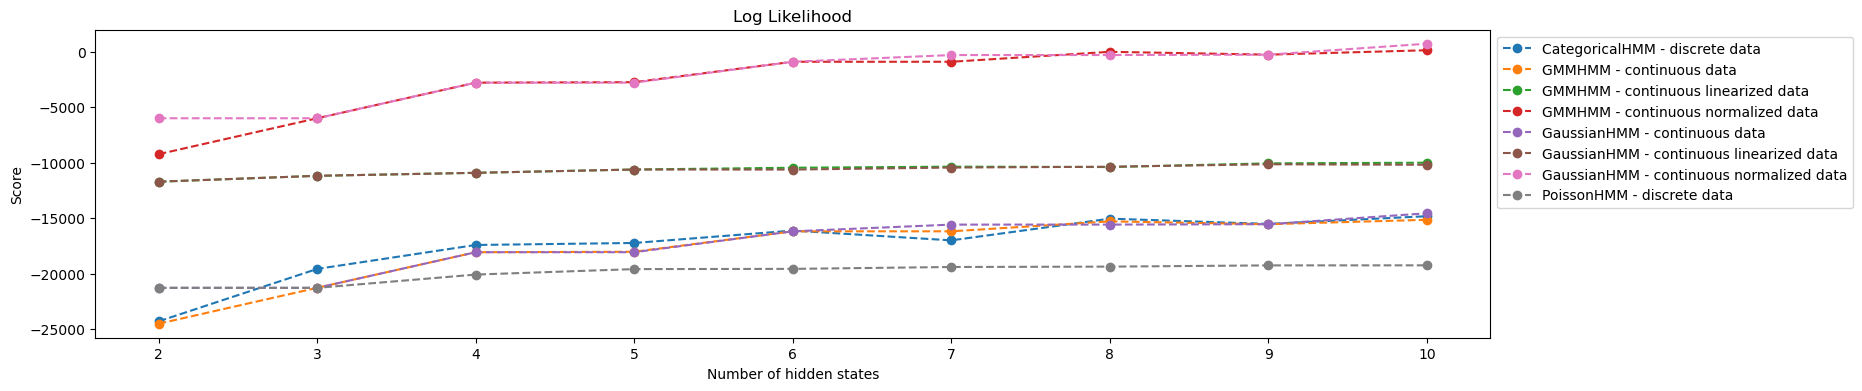

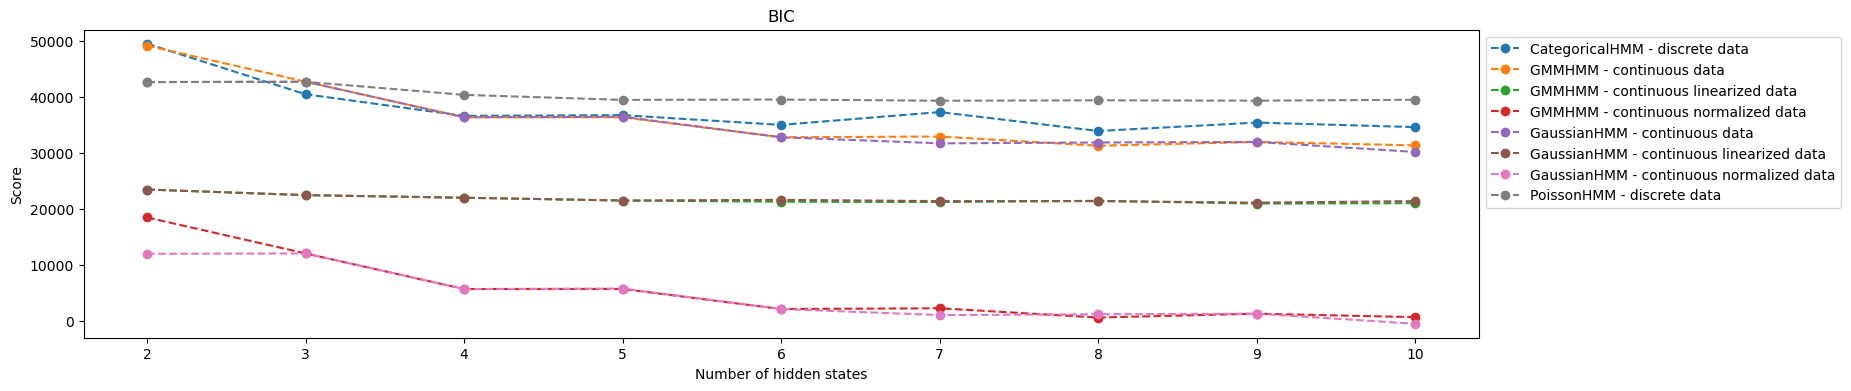

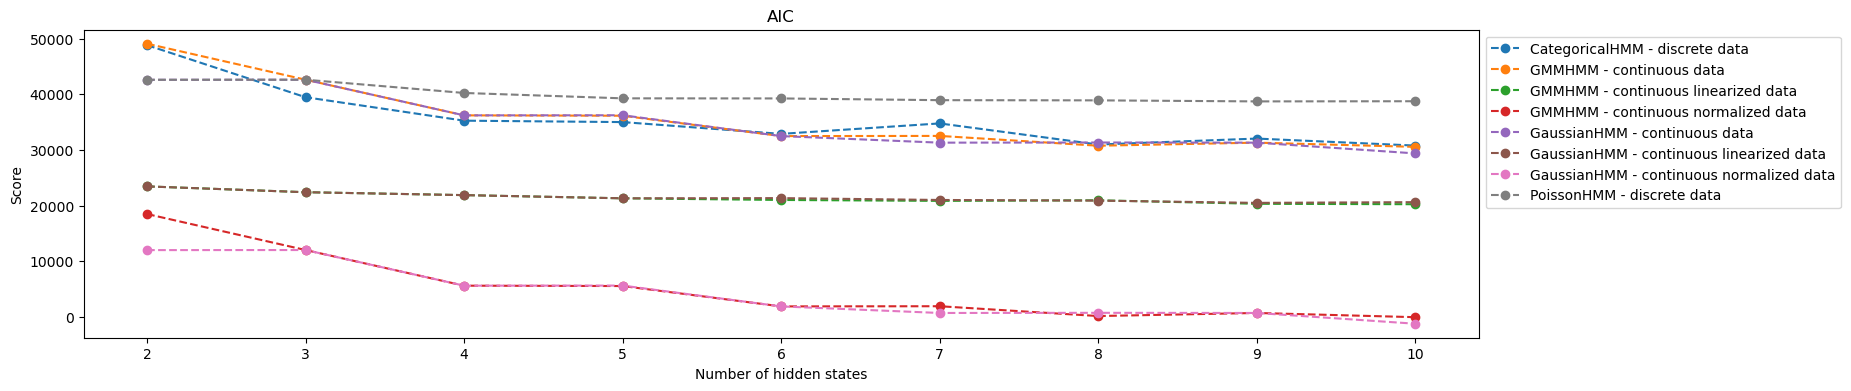

In [36]:
for metric_name in ['Log Likelihood', 'BIC', 'AIC']:
    plot_scores(model_df, metric_name)

To choose the best number of hidden states, we calculated log-likelihood (which we want to maximize), AIC, and BIC (which we want to minimize). However, since log-likelihood, as well as BIC and AIC, depend on the variance of the time series, these metrics alone are not sufficient to decide which model and with which time series we should make predictions.

As expected, log-likelihood increases with the increase of hidden states, while BIC and AIC exhibit a decreasing trend with increasing states.
So we obtained consistent results across all three metrics regarding the performance of each model, which was expected since the metrics are related.

Compare the performance of models on the same time series with different distribution emissions and numbers of hidden states:

- Regarding the original and normalized time series, we did not notice significant differences between the model using Gaussian and GMM emissions.

- The normalized time series is the one where the metrics achieve better values, and it is the only one where the likelihood reaches positive values. This result was expected because the normalized time series has a standard deviation of 1, which is lower than the other time series.
The metrics remain constant as the number of hidden states varies for the linearized series. This could be due to the nature of linearization, so it doesn't seem that increasing the number of hidden states improves the model.

- Models with discrete emission distributions performed worse than others (comparing the metrics), and for the categorical distribution, the metrics have constant values. This could be due to the limited capacity of Poisson and Categorical distributions to effectively model variations in the data.

Let's visualize what happened with the linearized data.

The figure below displays the hidden states assigned by a Gaussian emission distribution model with 3 (the model plotted in the two figures above) and 8 (the model shown in the figure below) hidden states trained on the linearized time series. The hidden states are presented first on the linearized time series and then mapped back to the original time series.

This comparison helps us interpret the underlying data dynamics.

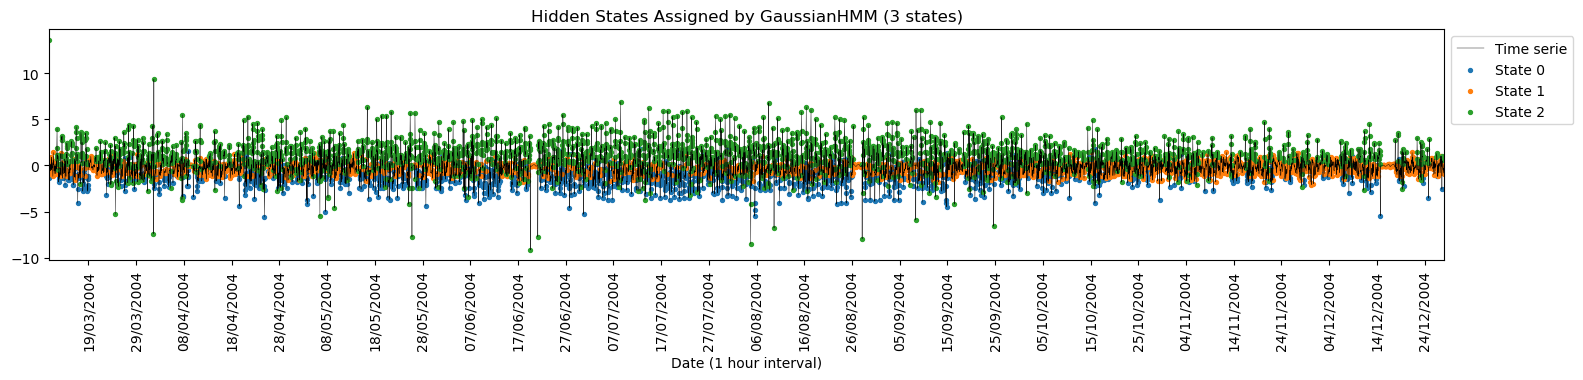

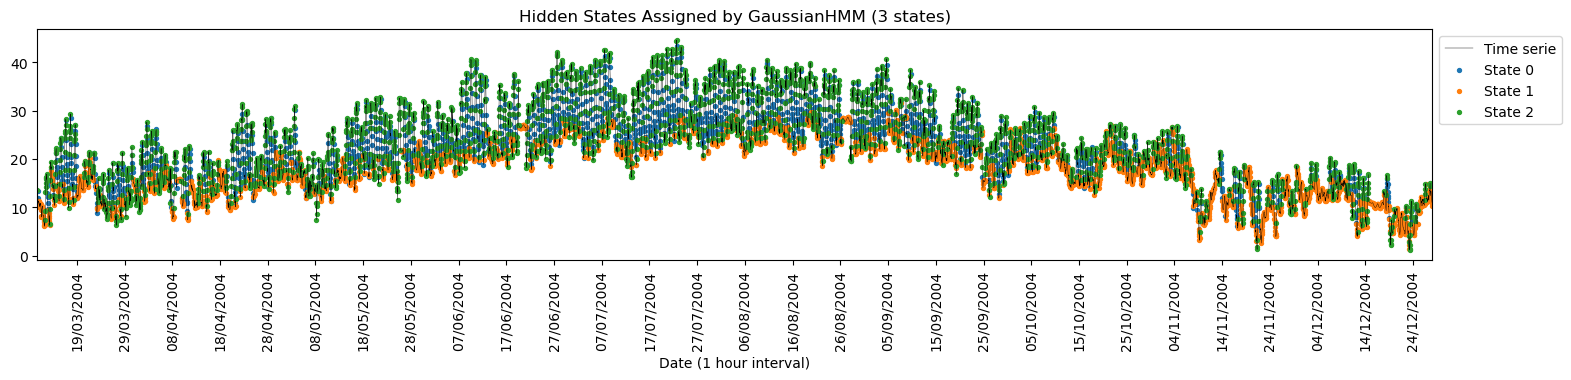

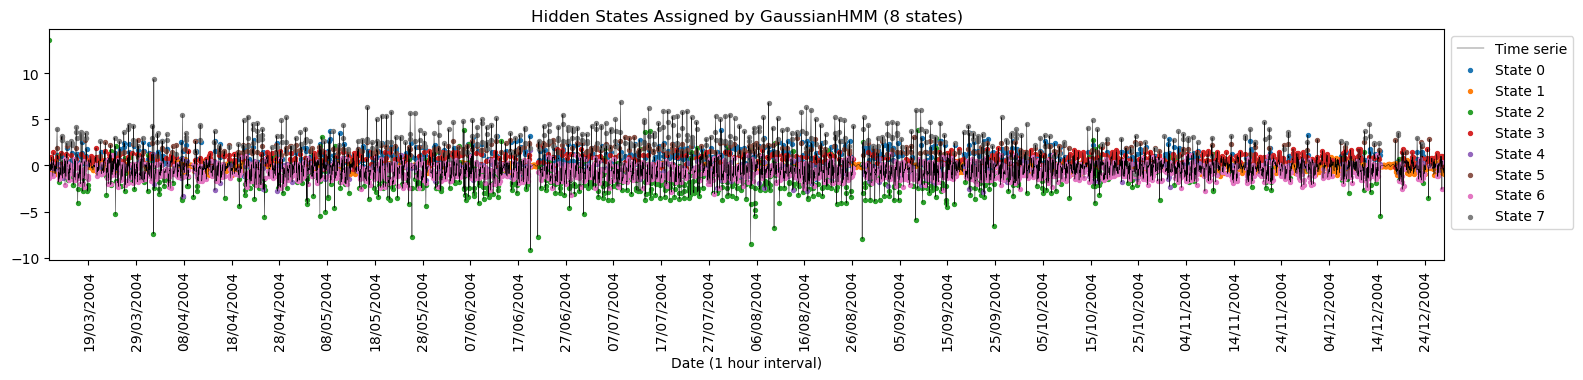

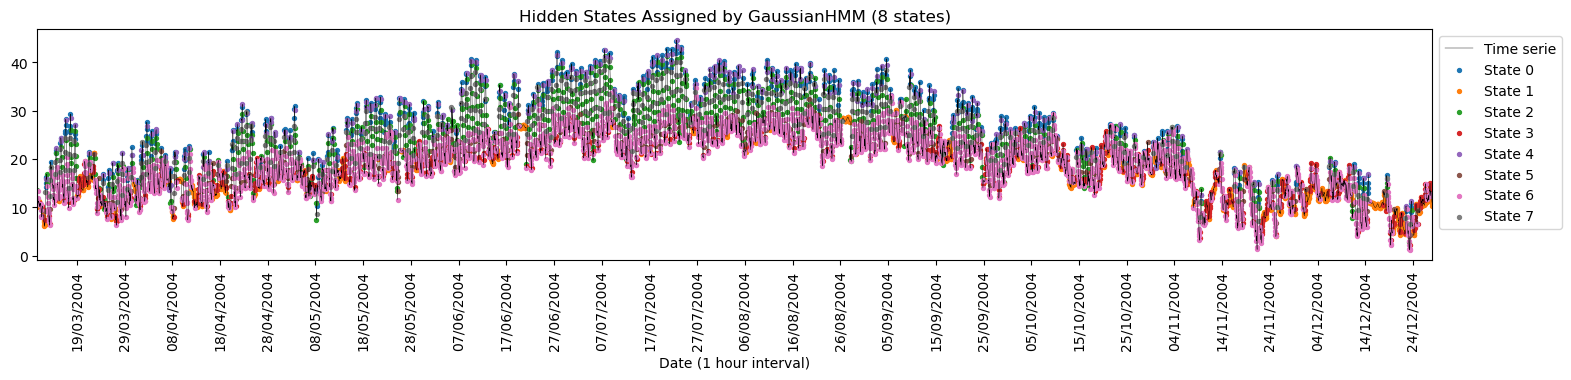

In [37]:
for n_components in [3, 8]:
    model = fit_continuous_hmm_model(train_data_linearized, n_components=n_components, model_name='GaussianHMM', algorithm='map')

    map_states = predict_hmm_states(model, train_data_linearized)
    visualize_hmm_states(train_data_linearized, map_states, n_components=n_components, model_name='GaussianHMM',
        unit_measure='', date_from=pd.to_datetime('2004-03-10 18:00:00'),
        date_to=pd.to_datetime('2004-03-10 18:00:00') + pd.DateOffset(hours=len(train_data_linearized)-1))
    visualize_hmm_states(train_data, map_states, n_components=n_components, model_name='GaussianHMM',
        unit_measure='', date_from=pd.to_datetime('2004-03-10 18:00:00'),
        date_to=pd.to_datetime('2004-03-10 18:00:00') + pd.DateOffset(hours=len(train_data_linearized)-1))

In the previous figures, both for the model with 3 hidden states and the one with 8, we observe that the model divides the hidden states based on the values of the corresponding emissions on the linearized time series. 

For the model with three hidden states, we notice a division into three bands, where one corresponds to emissions around zero (state 1), while the other two represent values above and below the mean, corresponding to states 2 and 0, respectively.

So the points assigned to hidden state 1 correspond to values that do not vary much or change little compared to the previous observation, i.e., the temperature measured the hour before. The emissions corresponding to hidden states 0 represent values where the temperature decreases, and state 2 corresponds to temperatures increasing compared to the previous measurement.

Upon mapping back to the original time series, we notice that emissions from hidden state 1 correspond to the lowest values reached by the time series, while emissions from state 2 seem to cover all possible values.

When mapping back to the original time series, the division into bands based on the emission values is not as clear-out.

For the model with 8 hidden states, similar considerations can be made.

Since using loglikelihood means choose the highest number of hidden states for each model, we opted to use BIC to determine the optimal number of hidden states.

In [38]:
# select best number of hidden state for each model
optimal_n_components_per_model = {}

for train_set_name in data_set_dict.keys():
    for model in model_df['Model'].unique():
        model_subset = model_df[(model_df['Model'] == model) & (model_df['DataSet'] == train_set_name)]
        try:
            best_states = model_subset[model_subset['BIC'] == model_subset['BIC'].min()]['States'].values[0]
            print(f'Best number of hidden states for {model} with {train_set_name} data: {best_states}')
            optimal_n_components_per_model[(model, train_set_name)] = best_states
        except:
            pass # discrete data in continuous model or continuous data in discrete model: not found, of course :)

Best number of hidden states for GaussianHMM with continuous data: 10
Best number of hidden states for GMMHMM with continuous data: 8
Best number of hidden states for GaussianHMM with continuous normalized data: 10
Best number of hidden states for GMMHMM with continuous normalized data: 8
Best number of hidden states for GaussianHMM with continuous linearized data: 9
Best number of hidden states for GMMHMM with continuous linearized data: 9
Best number of hidden states for CategoricalHMM with discrete data: 8
Best number of hidden states for PoissonHMM with discrete data: 7


### 3.2 Predict Samples to Choose Emission Distribuition

Now that we have selected the best number of hidden states for each model, our next step is to generate a number of random samples equal to the length of the test set and compare them with the actual test data to visualize which model is more accurate to make predictions.

Predictions are made using a model trained with temperatures taken from the months between March and December, and are compared with the test set containing data from December to March. Therefore, we expect that predictions for all models will be higher than the target.

It's important to note that the same random seed has been set to generate all samples for all models.

In [39]:
# find start date and end date of the subsequence, used for x-asix in the plots
len_series = len(data)
len_subseq = len(test_data)

date_from_subseq = pd.to_datetime('2004-03-10 18:00:00') + pd.DateOffset(hours=len_series - len_subseq)
date_to_subseq = pd.to_datetime('2005-04-04 14:00:00')

The figure below represents the time series generated by the models (in red) and their respective target (in black).

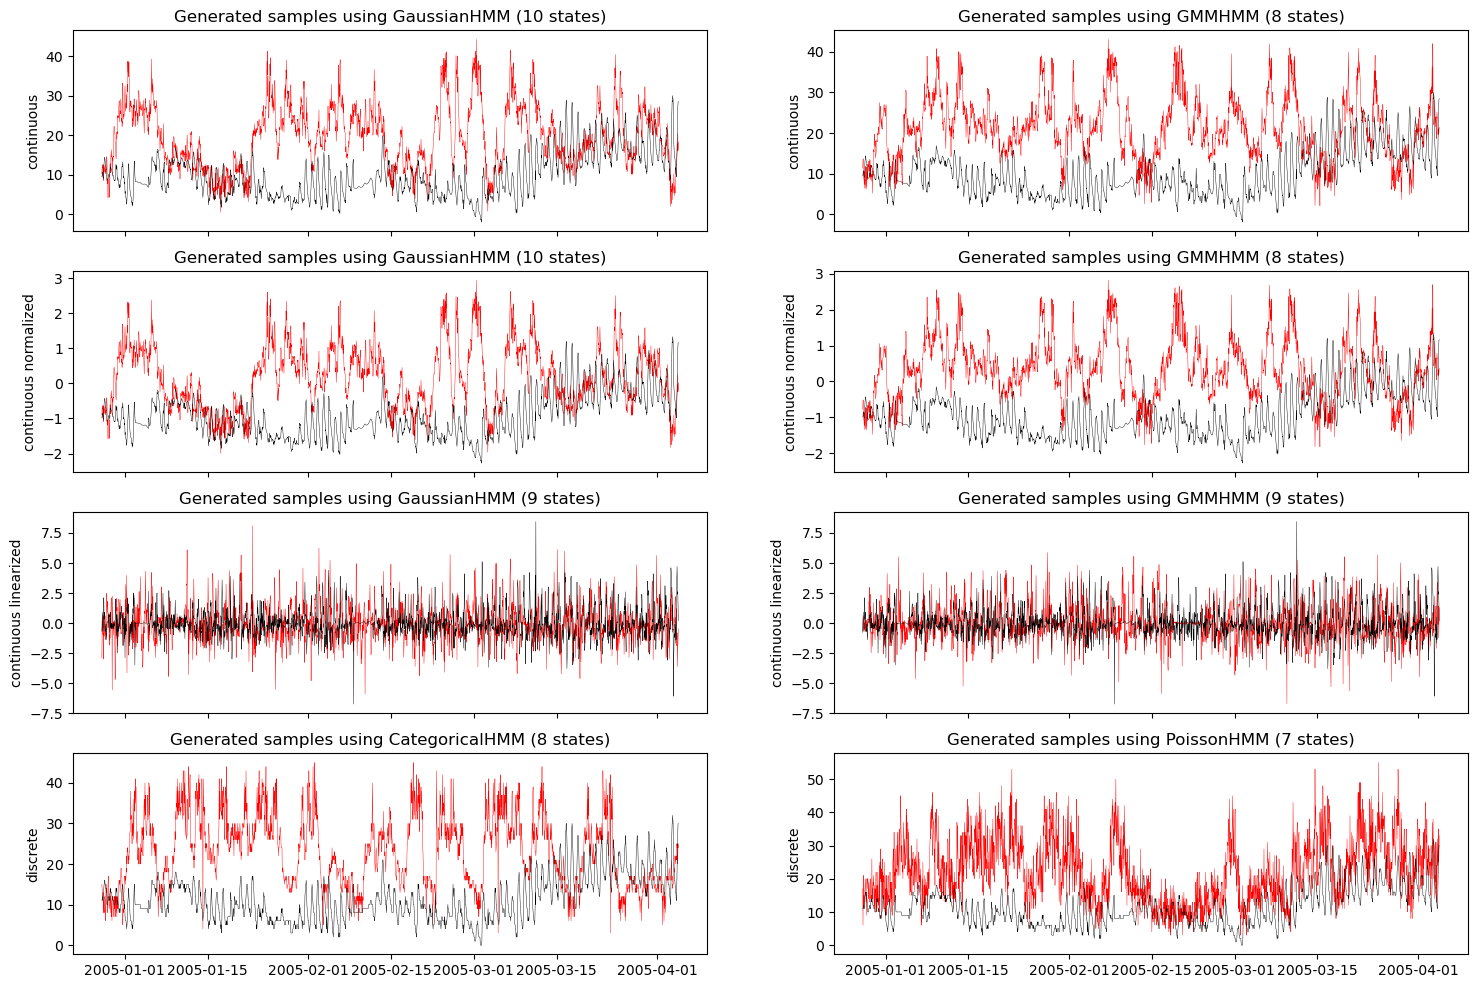

In [40]:
fig, axs = plt.subplots(4, 2, figsize=(18, 12), sharex=True)
for (hmm_name, data_type), n_components in optimal_n_components_per_model.items():
    train_set = data_set_dict[data_type][0]
    test_set = data_set_dict[data_type][1]
    ax = axs.flatten()[list(optimal_n_components_per_model.keys()).index((hmm_name, data_type))]
    generate_and_visualize_samples(hmm_name, data_type, n_components, train_set, test_set, ax=ax, 
        date_from=date_from_subseq, date_to=date_to_subseq)
plt.show()

- Having set the same random seed for all models allows us to observe that the model trained using the normalized time series generates samples that compose the same time series as those generated by the model trained with the original time series, but translated and compressed. This outcome was expected, and therefore, we could have avoided using the model with the normalized time series to generate the samples.

- Since using the model trained with the normalized samples does not provide any additional information compared to the original time series, we can choose to use the original one between the two.

- It is challenging to make a comparative analysis by examining the generated time series from model trained using the linearized time series and the target. The average of the generated linear times series is closed to the target compared to the others, but this is due to the linearization. However, considering the observations regarding the less distinct division into bands based on the emission value on the original time serie, we choose to discard these models.

- The time series generated by the model with Categorical emission distribution exhibits a similar trend to that generated by the Gaussian emission model, although upon visual analysis, the generated time series appears to deviate further from the target compared to the Gaussian distribution.

- Poisson emission yields significantly higher values compared to the time series generated from other models, resulting in a time series with more pronounced oscillations. It is to note that Poisson is not suitable for modeling temperature trends.

### 3.4 Choose Configuration

We compute the Euclidean distance between the generated time series and their target in order to obtain a quantitative value for comparing the quality of the generated time series.

Additionally, we visualize the distribution of the generated data and compare it with that of the original samples, both centered at 0.

Statistic for the real samples:


,Mean,Std
Orginal samples,9.870837,5.478523
Discretize samples,11.423504,5.490914


Distance between real and generated samples and their statistics:


,Distance,Mean,Std
GaussianHMM,690.674654,19.780399,7.91291
GMMHMM,669.760496,19.730099,7.768657
PoissonHMM,691.290822,21.052991,8.699038
CategoricalHMM,726.885135,22.627778,8.443649


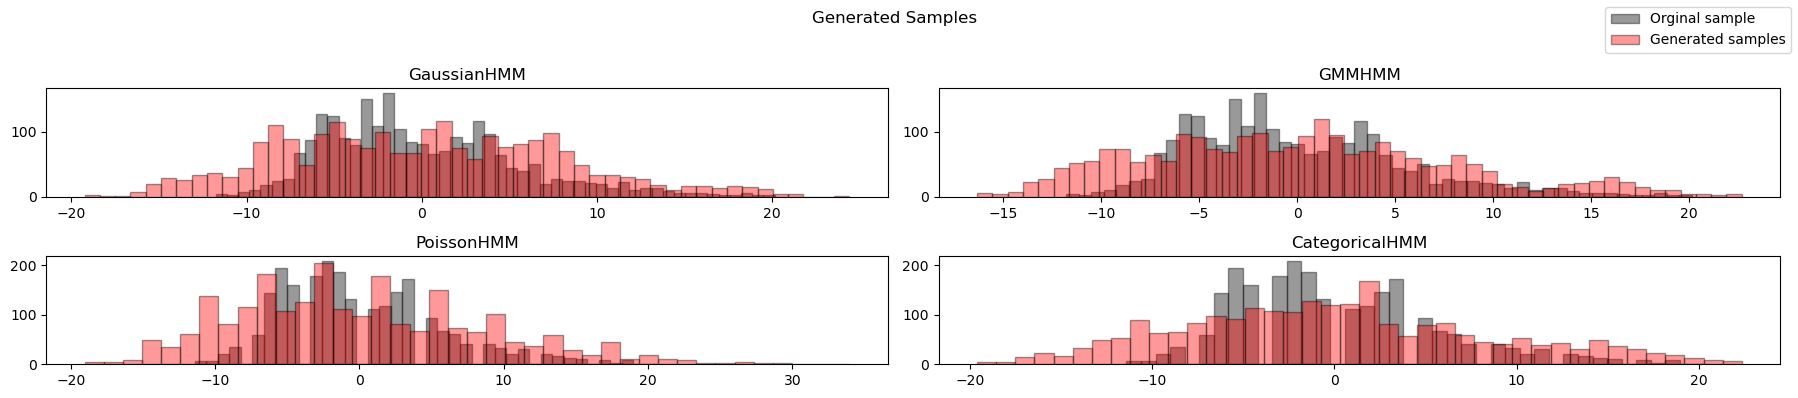

In [41]:
# measures distance between two time series
def compute_distance(time_serie1, time_serie2):
    return np.linalg.norm(time_serie1 - time_serie2) # Euclidean distance

distance_df = pd.DataFrame(columns=['Distance', 'Mean', 'Std'])
fig, axs = plt.subplots(2, 2, figsize=(18, 4))

# compute distance between real samples and generated samples
for model, n_hidden_states in zip(['GaussianHMM', 'GMMHMM'], [10, 9]):
    ts_generated, _ = generate_samples(model, 'continuous', n_hidden_states, train_data, n_samples=len(test_data))
    distance_df.loc[model, 'Distance'] = compute_distance(ts_generated, test_data)
    distance_df.loc[model, 'Mean'] = np.mean(ts_generated)
    distance_df.loc[model, 'Std'] = np.std(ts_generated)
    i = ['GaussianHMM', 'GMMHMM'].index(model)
    axs[0, i].hist(test_data-np.mean(test_data), bins=50, color='k', alpha=0.4, edgecolor='black')
    axs[0, i].hist(ts_generated-np.mean(ts_generated), bins=50, color='red', alpha=0.4, edgecolor='black')
    axs[0, i].set_title(model)

for model, n_hidden_states in zip(['PoissonHMM', 'CategoricalHMM'], [8, 7]):
    ts_generated, _ = generate_samples(model, 'discrete', n_hidden_states, train_data_discretized, n_samples=len(test_data))
    distance_df.loc[model, 'Distance'] = compute_distance(ts_generated, test_data_discretized)
    distance_df.loc[model, 'Mean'] = np.mean(ts_generated)
    distance_df.loc[model, 'Std'] = np.std(ts_generated)
    i = ['PoissonHMM', 'CategoricalHMM'].index(model)
    axs[1, i].hist(test_data_discretized-np.mean(test_data_discretized), bins=40, color='k', alpha=0.4, edgecolor='black')
    axs[1, i].hist(ts_generated-np.mean(ts_generated), bins=40, color='red', alpha=0.4, edgecolor='black')
    axs[1, i].set_title(model)

test_statistic_df = pd.DataFrame(columns=['Mean', 'Std'])
test_statistic_df.loc['Orginal samples'] = np.mean(test_data), np.std(test_data)
test_statistic_df.loc['Discretize samples'] = np.mean(test_data_discretized), np.std(test_data_discretized)

print('Statistic for the real samples:')
display(test_statistic_df)

print('Distance between real and generated samples and their statistics:')
display(distance_df)

fig.suptitle('Generated Samples')
fig.tight_layout(rect=[0, 0, 1, 0.95])
fig.legend(['Orginal sample', 'Generated samples'], loc='upper right')
plt.show()

Observations:
- The mean and standard deviation of the generated time series are naturally close to those of the training data (average: 18.19, std: 8.85), while the test data used for comparison have a lower mean (as they correspond to the winter months).
- The distributions have been plotted centered at 0 for a clearer visual comparison.

Based on these observations, we can conclude that no model significantly outperforms the others. Therefore, we opt to use the model with Gaussian Mixture Model (GMM) emission distribution since it minimizes the metric, and a visual comparison of the distributions seems satisfactory.

## 4. Optimal State Assignement

Selected the best model, we re-trained the hmm with the selected parameters using all available data. Then, we visualized the state assignments on the last 25% of the time series (from late december to late march) using both the Verbi algorithm and the best state according to the hidden state posterior.

In [42]:
optimal_model_name = 'GMMHMM'
optimal_n_components = 10

data_to_fit = data # use original data to fit the model
test_data_to_fit = test_data

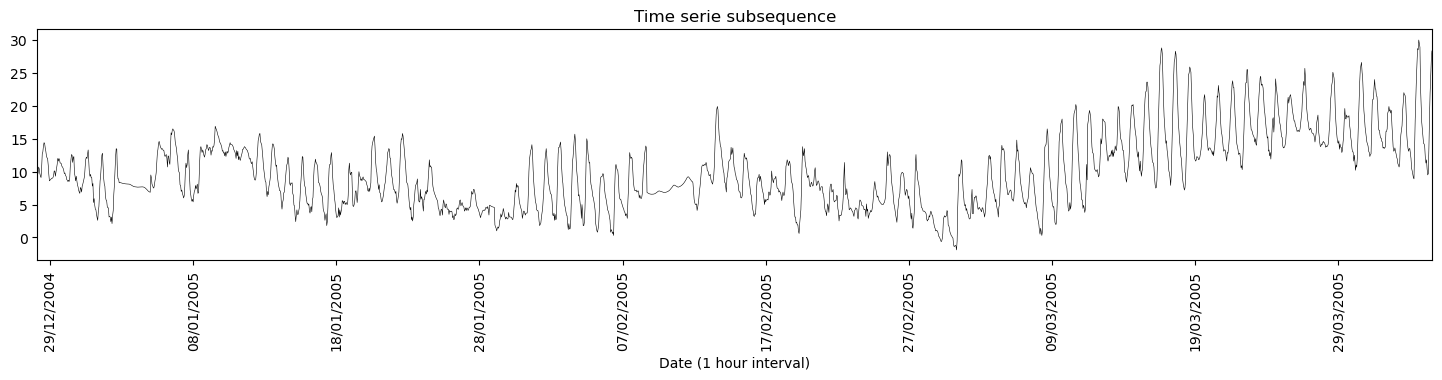

In [43]:
visualize_ts(test_data_to_fit, title='Time serie subsequence', unit_measure='',
    date_from=date_from_subseq, date_to=date_to_subseq)

We visualize the transition matrix:

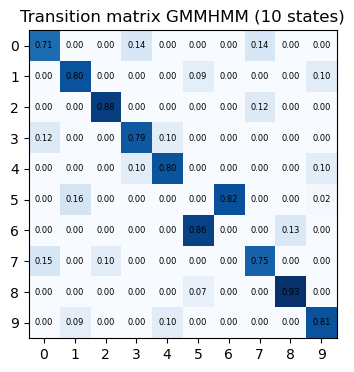

In [44]:
viterbi_model = fit_continuous_hmm_model(data_to_fit, n_components=optimal_n_components, model_name=optimal_model_name, 
    algorithm='viterbi')

visualize_hmm_states_transition_matrix(viterbi_model, n_components=optimal_n_components, model_name=optimal_model_name)

- Transition probabilities are predominantly concentrated along the diagonal, indicating a tendency to remain in the same state.

- Exceptions are observed in states 5 and 6, where the transition probability of staying in those states is 0 (if in state 5, the probability of remaining is 0, and the same applies to state 6), while almost all the transition probability is between state 5 and 6 and vice versa.

- Excluding states 5 and 6, we observe low transition probabilities between different states. Furthermore, from each state, transitions are limited to a subset of other states (from one state, I can only transition to 1 or 2 different states in one time step), with transitions between different states occurring with low probability.

### 4.1 Viterbi

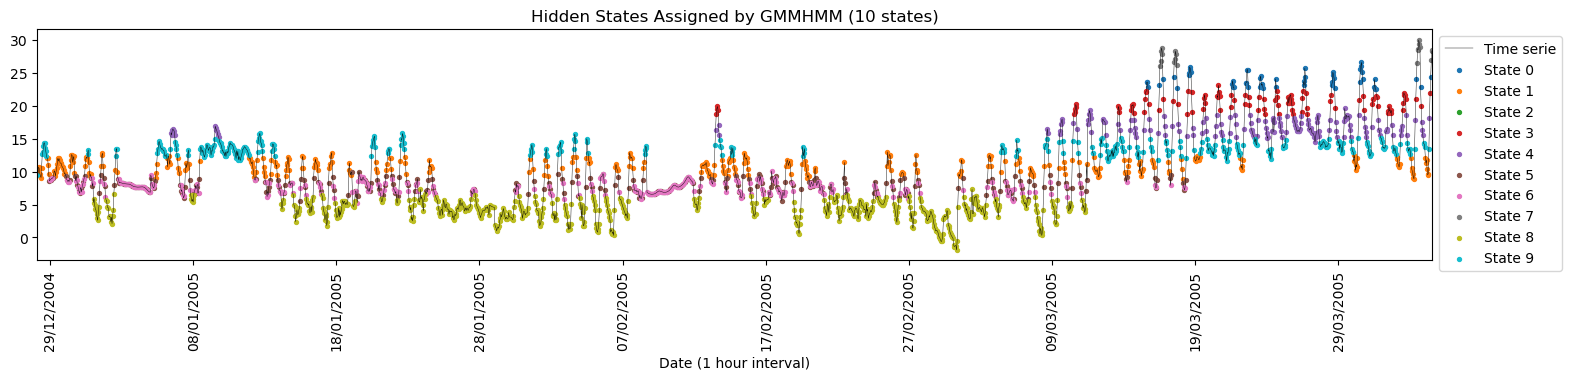

In [45]:
viterbi_states = predict_hmm_states(viterbi_model, test_data_to_fit)
visualize_hmm_states(test_data_to_fit, viterbi_states, n_components=optimal_n_components, model_name=optimal_model_name,
    unit_measure='', date_from=date_from_subseq, date_to=date_to_subseq)

From the visualization of the hidden states assigned to the time series using the Viterbi algorithm, we can observe the following:

- There is a relatively clear division into bands, except for state 5 (in pink) and state 6 (in brown). We do not observe a distinct separation between these two states: they appear mixed together, as expected.

- The division into bands is horizontal, with each hidden state associated with a range of emissions.

### 4.2 Best State according to Hidden State Posterior

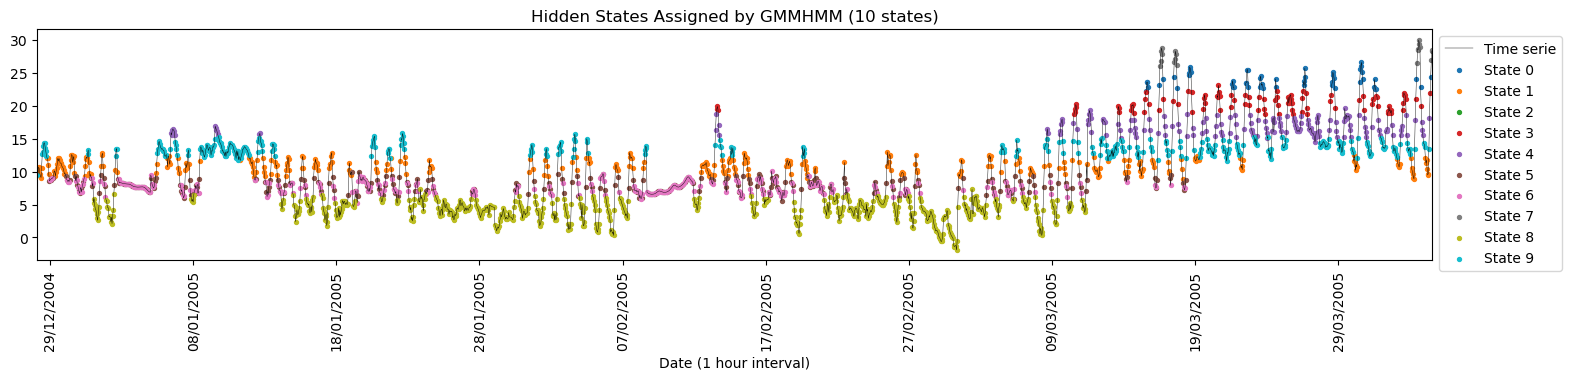

In [46]:
map_model = fit_continuous_hmm_model(data_to_fit, n_components=optimal_n_components, model_name=optimal_model_name, 
    algorithm='map')

map_states = predict_hmm_states(map_model, test_data_to_fit)
visualize_hmm_states(test_data_to_fit, map_states, n_components=optimal_n_components, model_name=optimal_model_name,
    unit_measure='', date_from=date_from_subseq, date_to=date_to_subseq)

From a visual comparison of the hidden states assigned to the time series according to the hidden state posterior, we do not observe any differences compared to the hidden states assigned by the Viterbi algorithm. 

The observations made above still hold true.

### 4.3 Compare states assigned by Viterbi and MAP algorithms

We visualize the states assigned differently by the two algorithms.

Number of different states assigned by Viterbi and MAP: 39 out of 2340 (1.67%).


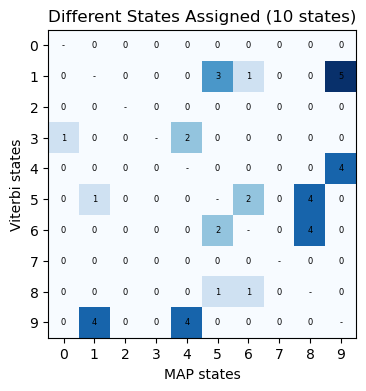

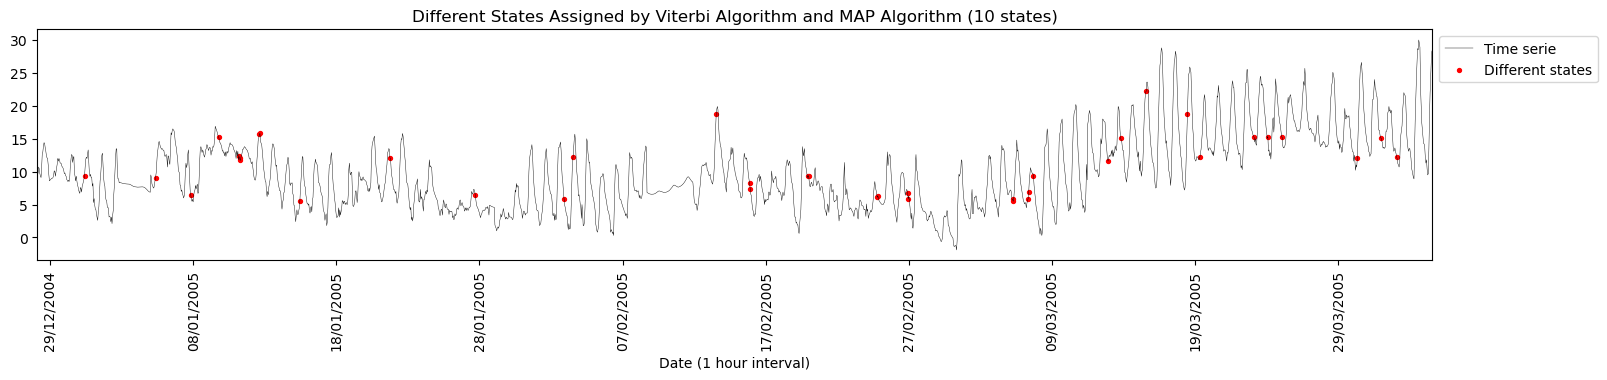

In [47]:
display_different_states_assigned(viterbi_states, map_states, n_components=optimal_n_components,
    model_name1='Viterbi', model_name2='MAP')

visualize_different_states_assigned(test_data_to_fit, viterbi_states, map_states, optimal_n_components,
    'Viterbi Algorithm', 'MAP Algorithm', unit_measure='', date_from=date_from_subseq, date_to=date_to_subseq)

Only a few states do not match between the assignments made by one algorithm and the other. The highest number of mismatches is between states 9 and 1, and 4 and 9.

If we observe from the plots of the hidden states reported above, we can see that these states are consecutive within the emission band. Therefore, there is a variation in the assignments on observations that correspond to values between one band and another.

Considering the assignment of hidden states as a clustering algorithm, we can notice that the points that do not correspond between one algorithm and the other are those at the boundary of a cluster, which are clustered into a neighboring one.

Therefore, we can conclude that there is no significant difference between the optimal states assigned by one algorithm or the other.